<a href="https://colab.research.google.com/github/dewidiah1212/CNN-Sales-Prediction/blob/main/cnn_marketingcampaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
101/101 [==============================] - 3s 5ms/step - loss: 0.6930 - accuracy: 0.5037 - val_loss: 0.6927 - val_accuracy: 0.4854
Epoch 2/100
101/101 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.5027 - val_loss: 0.6845 - val_accuracy: 0.4854
Epoch 3/100
101/101 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6398 - val_loss: 0.6340 - val_accuracy: 0.6830
Epoch 4/100
101/101 [==============================] - 0s 3ms/step - loss: 0.5973 - accuracy: 0.7364 - val_loss: 0.6046 - val_accuracy: 0.7414
Epoch 5/100
101/101 [==============================] - 0s 3ms/step - loss: 0.5766 - accuracy: 0.7576 - val_loss: 0.5846 - val_accuracy: 0.7414
Epoch 6/100
101/101 [==============================] - 0s 3ms/step - loss: 0.5610 - accuracy: 0.7656 - val_loss: 0.5703 - val_accuracy: 0.7546
Epoch 7/100
101/101 [==============================] - 0s 3ms/step - loss: 0.5474 - accuracy: 0.7742 - val_loss: 0.5561 - val_accuracy: 0.7666

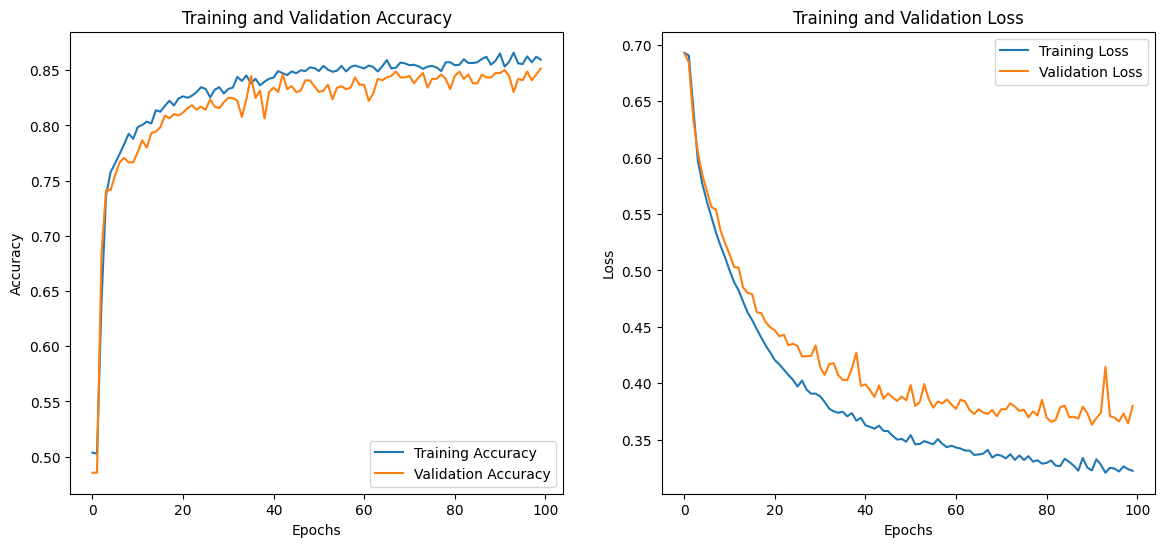

24/24 [==============================] - 0s 2ms/step
Accuracy on balanced subset: 87.00%


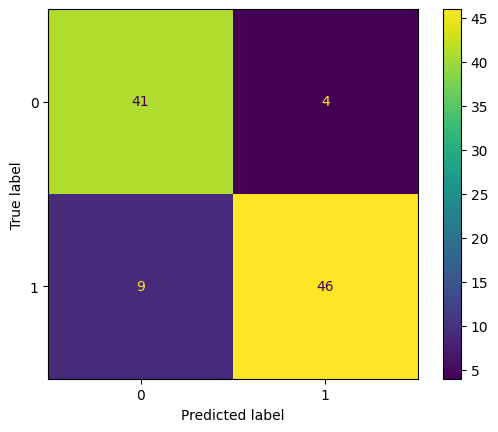

              precision    recall  f1-score   support

           0       0.82      0.91      0.86        45
           1       0.92      0.84      0.88        55

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Load and process dataset
dataset = pd.read_excel(r"/content/marketing_campaign.xlsx")
data = dataset.iloc[:, [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 28]]

# One-hot encoding for categorical variables
dummies = pd.get_dummies(data, prefix='EDU_', columns=['Education'])
data1 = pd.get_dummies(dummies, prefix='MAT_', columns=['Marital_Status'])
data1 = data1[[col for col in data1.columns if col != 'Response'] + ["Response"]]

# Drop NA values
data2 = data1.dropna()

# Feature and target variables
x = data2.iloc[:, :-1].values
y = data2.iloc[:, -1].values

# Resampling to handle imbalanced dataset
s = SMOTE()
x_data, y_data = s.fit_resample(x, y)

# Scaling features
mms = MinMaxScaler()
x_scaled = mms.fit_transform(x_data)

# Split dataset into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_data, test_size=0.2, random_state=20)

# Define and compile CNN model
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Dense(units=7, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=6, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=5, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=5, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=5, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=5, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model = cnn.fit(x_train, y_train, batch_size=30, epochs=100, validation_data=(x_test, y_test))

# Plot accuracy and loss
history = cnn_model.history

plt.figure(figsize=(14, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Predictions and evaluation
cnn_pred = cnn.predict(x_test)
cnn_pred = (cnn_pred > 0.5).astype(int)

# Create a balanced subset of predictions
pred_class_1_indices = np.where(cnn_pred == 1)[0]
pred_class_0_indices = np.where(cnn_pred == 0)[0]

# Ensure we have at least 50 samples of each class
n_samples_per_class = 50
balanced_indices = np.hstack((
    pred_class_1_indices[:n_samples_per_class],
    pred_class_0_indices[:n_samples_per_class]
))

balanced_x_test = x_test[balanced_indices]
balanced_y_test = y_test[balanced_indices]
balanced_cnn_pred = cnn_pred[balanced_indices]

# Evaluate the balanced subset
cnn_accuracy = accuracy_score(balanced_y_test, balanced_cnn_pred)
print(f'Accuracy on balanced subset: {cnn_accuracy * 100:.2f}%')

cm = confusion_matrix(balanced_y_test, balanced_cnn_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()
plt.show()

print(classification_report(balanced_y_test, balanced_cnn_pred))
